### **Submission rules**:
1. The completed assignment should be prepared as a Google Colab notebook. Please make a copy of this notebook for your team. Submit the link to the notebook to cms and open it via UCU email address.
2. There should be only one submission per team. However, don't forget to choose a person from your team who would submit the task, and make sure that the names of all team members are listed in the notebook. Teammates not mentioned in the notebook will not be graded for this lab.
3. You also need to provide a work breakdown structure estimating the efforts of each team member. Please provide it at the top of your notebook.
4. The final deadline is May 9 2023, 23:59. 

**IMPORTANT:** Making any changes to your code after this time and date is forbidden and will be a reason for point deduction for the whole team.

**Team**: Vladyslav Humennyy, Svitlana Hovorova, Volodymyr Kuzma.

**Work breakdown**: 
- *Svitlana Hovorova* - explanations and calculating singular values for symmetric matrix. 
- *Vladyslav Humennyy* - code checking and comparing SVD quality with other compression method.
- *Volodymyr Kuzma* - code for reduced SVD, compressed_size function and upper/lower bounds of k.

# Image compression with SVD

The singular value decomposition of a matrix A is the factorization of A into the
product of three matrices:
\begin{align}
 A = UDV^T, 
 \end{align}
where the columns of U and V are orthonormal and
the matrix D is diagonal with positive real entries. The SVD is useful in many tasks. First, in many applications, the data matrix A is close to a
matrix of low rank and it is useful to find a low rank matrix which is a good approximation
to the data matrix. You will show that from the singular value decomposition of A, we can get the matrix B of rank k which best approximates A; in fact, we can do this for every
k. Also, singular value decomposition is defined for all matrices (rectangular or square) unlike spectral decomposition, although the latter one is used more commonly in Linear Algebra.

Considering that any image can be represented as a rectangular matrix, you can find the best rank k approximation of this image using SVD. The idea is that by significantly reducing the storage space, you can still preserve a very good quality of the image

In [ ]:
!pip install pytorch-msssim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab.patches import cv2_imshow
import cv2 as cv
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget
from PIL import Image
from sys import getsizeof
import os

### SVD of symmetric matrices (0.5 pts)

Here you have a symmetric matrix A. Compute a full SVD of this matrix (you may use built-in SVD functions).

In [ ]:
A = np.array([[1, 2, 3, 4], [2, 7, 4, 5], [3, 4, 3, 8], [4, 5, 8, 3]])


# U - matrix with columns eigenvectors of AA^T (represents U in UDV^T form of SVD)
# S - array of singular values of A in descending order (represents values on the main diagonal of D in UDV^T)
# Vh - matrix with rows eigenvectors of A^TA (represents V^T in UDV^T form of SVD)
U, S, Vh = np.linalg.svd(A)
V = Vh.T

# The following lines are to prove that the decomposition worked
B = U@np.diag(S)@Vh
np.isclose(A,B).all()

True

Explain what matrices did you get as a result. What can you say about singular values of this matrix (about its eigenvalues)? Derive singular values without using built-in functions.

Result of $SVD$ algorithm is 3 matrices which when multiplied are equal to initial $A$. Matrix $U$ is a matrix of $AA^{T}$ matrix eigenvectors, $D$ is matrix of singular values of $A$ (square roots of eigenvalues of $A^{T}A$ matrix) and $V$ - matrix of $A^{T}A$ matrix normalized (of unit length) eigenvectors. As we have a square symmetric non-singular matrix, its eigenvaues are real and non-zero. As $A^{T}A = A^{2}$, the relation between $A$'s eigenvalues and singular values is such that they are equal up to the sign: singular values are non-negative.

In [ ]:
eig_valsA, _= np.linalg.eig(A)
singular_vals_A = np.abs(eig_valsA)

print(np.sort(S))
print(np.sort(singular_vals_A))

[ 0.97581683  2.79573697  5.15839249 17.33847234]
[ 0.97581683  2.79573697  5.15839249 17.33847234]


How $SVD$ relates to matrises $Q, D, Q^T$ in spectral decomposition of this matrix? Are they identical? If they are, can you say that SVD of symmetric matrices always corresponds to its spectral decomposition? If not, then is it possible to find such symmetric matrises that SVD and spectral decomposition are identical?

$SVD$ and spectral decomposition matrices for some symmetric matrix $A$ are not necessarily identical, as singular values are non-negative and there is no such restriction on eigenvalues of a symmetric matrix (we only know for sure that they are real). Given matrix A from previous part also has a negative eigenvalue, so its $SVD$ is not identical to spectral decomposition. However, it is possible to find such symmetric matrices for which these matrices are identical. **It works in case of positive semi-definite matrices**, as $|\lambda|$ = $\lambda$ for non-negative numbers. In cases where the negative eigenvalues are present, the corresponding eigenvectors in $U$ and $V$ will be of opposite sign: $u_i = - v_i$, so that $\sigma_iu_i v_i^T = -\sigma_iv_i v_i^T = \lambda_iv_i v_i^T$, meaning that $U$ and $V$ will have some columns with values of same modulus and opposite signs, so $U \neq V$.

### Image compression using SVD (1.5 pts)

Upload the picture of a dog. 

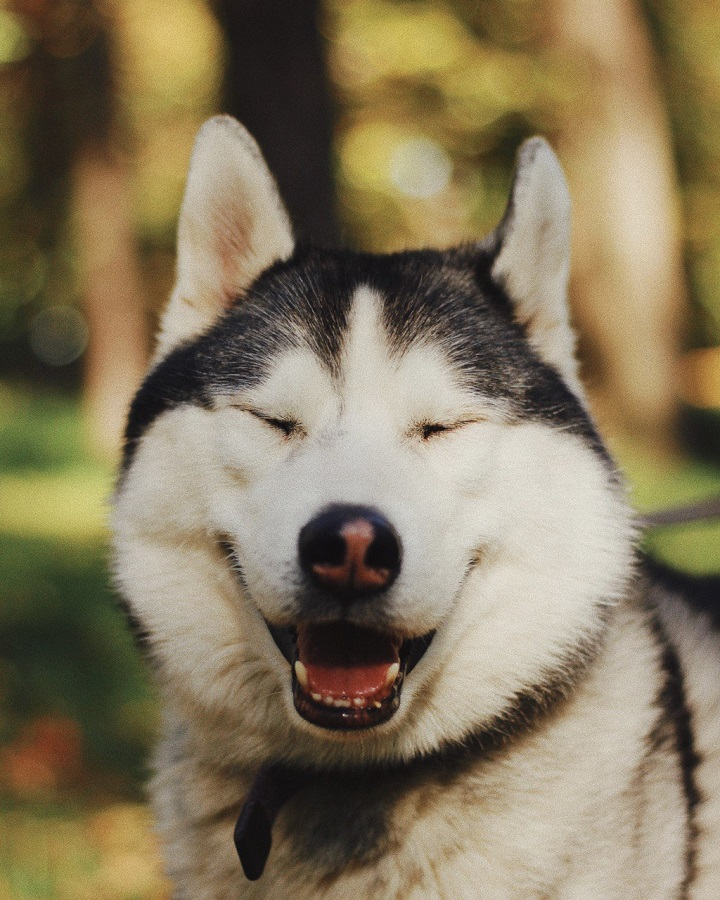

In [ ]:
path = '/content/happy-dog.jpg'
image = cv.imread(path)
image = image.astype('float32')
cv2_imshow(image)

Complete the below function for finding a reduced SVD of a given matrix. (You may use the functions for finding eigenvalues of the matrix). Highlight the key differences between SVD and the reduced version of it.

In [ ]:
def reduced_svd(A):
  '''
  Input: any matrix A
  Returns: tuple of matrix U, array of singular values and matrix V.T 
  '''

  # when comparing eigenvalues to 0 we need to have appropriate tolerance level as it is floating point number
  tolerance = 1e-06

  eigv_ATA, eigvc_ATA = np.linalg.eig(A.T@A)
  # next variable is used to order eigenvectors and eigenvalues in descending order as in np.linalg.svd
  order = np.argsort(eigv_ATA)[::-1]

  eigv_ATA = eigv_ATA[order]
  eigvc_ATA = eigvc_ATA[:,order][:,~np.isclose(eigv_ATA,0,atol=tolerance)]

  singular_values = np.sqrt(eigv_ATA)[~np.isclose(eigv_ATA,0,atol=tolerance)]
  V = eigvc_ATA

  U = A@V/singular_values

  return U, singular_values, V.T

# A = np.array([[-1.5, 3.2],[0.8, -2.4],[2.7, 1.1],[-3.0, -0.9],[1.2, 2.3]])
# a,b,c = reduced_svd(A)
# np.isclose(a@np.diag(b)@c, A, atol = 1e-06).all()

The reduced $SVD$ basically chops off all the unimportant data: if a matrix $A$ is of rank $r$, it has only $r$ positive singular values. Other are zeros.
Thus, the reduced $SVD$ gets rid of those zero values $\sigma_i$ and corresponding left and right singular vectors that results in $m \times r$ matrix $U$, 
$r \times r$ matrix $\Sigma$ and $r \times n$ matrix $V^T$.

Inspite of that, the reduced $SVD$ still returns us the matrix $A$!

Complete the function below. It should output the k-rank approximation of the given image using previously written SVD function. Use the slider to see how the image quality changes as we increase/decrease k.

For simplification, you can convert your image to a grayscale. However, it will be appreciated if you work with RGB channels (it is possible that you'll need to modify the method below a little).

In [ ]:
min_rank_over_colors = np.min([np.linalg.matrix_rank(image[:, :, c]) for c in range(3)])

first_chan, second_chan, third_chan = cv.split(image)

first_chan_u, first_chan_s, first_chan_vt = reduced_svd(first_chan)
second_chan_u, second_chan_s, second_chan_vt = reduced_svd(second_chan)
third_chan_u, third_chan_s, third_chan_vt = reduced_svd(third_chan)

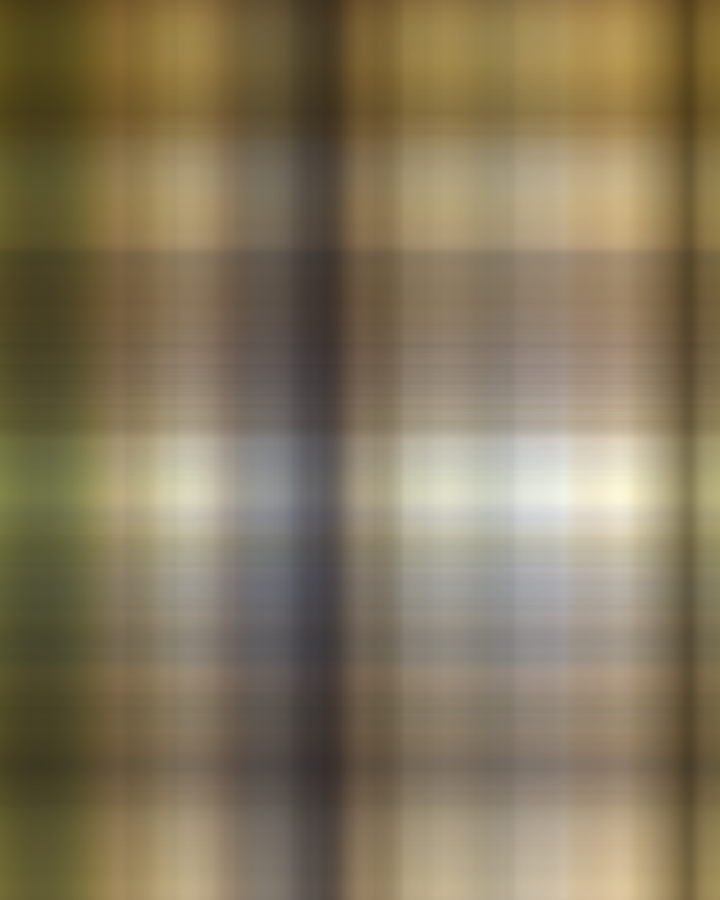

array([[[ 24.46861267,  69.25260162,  82.82264709],
        [ 24.2180233 ,  68.95605469,  82.28768921],
        [ 24.26195145,  68.68437195,  81.94647217],
        ...,
        [ 41.8008461 ,  92.83442688, 117.33129883],
        [ 41.93831253,  93.02896881, 117.70497894],
        [ 41.92205429,  93.20992279, 117.87588501]],

       [[ 24.64833832,  69.59898376,  83.19582367],
        [ 24.39591026,  69.30095673,  82.65844727],
        [ 24.44016075,  69.02790833,  82.31569672],
        ...,
        [ 42.10788345,  93.29875946, 117.85996246],
        [ 42.24635696,  93.49427795, 118.23531342],
        [ 42.22998047,  93.6761322 , 118.40699005]],

       [[ 24.72404099,  69.96144867,  83.54306793],
        [ 24.47083473,  69.66186523,  83.00345612],
        [ 24.51522255,  69.38739014,  82.65926361],
        ...,
        [ 42.23720932,  93.78464508, 118.35188293],
        [ 42.37610626,  93.98117828, 118.72880554],
        [ 42.35968018,  94.16398621, 118.90120697]],

       ...,

      

In [ ]:
@interact(k=widget.IntSlider(min=1, max=min_rank_over_colors), image=fixed(image))
def k_rank_compressed_image(k, image):
  
    approximated = np.zeros(image.shape)

    for i in range(k):
      approximated[:,:,0] += first_chan_s[i]*np.outer(first_chan_u[:,i], first_chan_vt[i])
      approximated[:,:,1] += second_chan_s[i]*np.outer(second_chan_u[:,i], second_chan_vt[i])
      approximated[:,:,2] += third_chan_s[i]*np.outer(third_chan_u[:,i], third_chan_vt[i])
    
    cv2_imshow(approximated)
    return approximated

In general, compressing the image to 60-80% percent of its original size  lowers its quality but human eye won't be even able to notice it. Therefore, we can win in storage while keeping almost the same image quality. Find out the range of $k$'s which result in keeping only 60-80% of the size of the original image. For what $k$'s there is no reason to use SVD for the sake of reducing storage space?

In [ ]:
# The matrix that reduced SVD returns has each element of 4 bytes. The original image is 1 byte per 1 color per pixel.

def compressed_size(k, image):

  # With every additional unit to k we add to three channels two arrays of size n and m
  # and one singular values which must be multiplied to get the image. Therefore, we can derive
  # the formula for overall compressed size (with each value in each array needing 4 bytes).

  num_of_channels = 3
  itemsize = 4
  x, y, _ = image.shape
  size_comp = (x + y + 1)*num_of_channels*itemsize*k

  return size_comp

In [ ]:
lower_bound_k = upper_bound_k = compression_limit = 0

image_size = image.shape[0]*image.shape[1]*image.shape[2] # each element is 1 byte

for k in range(min_rank_over_colors):
  comp_size = compressed_size(k, image)
  if comp_size < 0.6 * image_size:  # we find the last point at which the comp_size < 0.6 image_size so we will need to add 1 later to get lower bound
    lower_bound_k = k
  if comp_size < 0.8 * image_size:  # we find the last point at which the comp_size < 0.8 image_size - it is upper bound
    upper_bound_k = k
  if comp_size < image_size:  # we find the last point at which the comp_size < image_size - it is compression limit
    compression_limit = k

lower_bound_k += 1

print("Range of k for 60-80% compression:", lower_bound_k, "-", upper_bound_k)
print("It makes no sense for compression with SVD for k more than:", compression_limit)

Range of k for 60-80% compression: 60 - 79
It makes no sense for compression with SVD for k more than: 99


### Results (1 pt) 
Choose some metric for determining how good the compression with SVD is. Experiment with other compression algorithms (DCT, for instance). Compare it with SVD. Be creative;)

To find out, how good is our image after compression we used our metric SVV - system for visual validation. The main characteristics of the image, that we use for our result is the result of structural similarity of our photos. With use of skimage library we import function to get Multi-Scale Structural Similarity (MS-SSIM). It would be the base of our metric. Also, we want to subtract  compression rate, as we want to include that part of compression in our metric. Here how the metric looks:

$SVV = MSSSIM - CR$

Here are computations of that vector for our SVD and built-in jpeq compression:

In [ ]:
from skimage.metrics import structural_similarity as compare_ssim

def svv(compressed_image, compressed_image_size, reference_image, reference_image_size):
  mssim = compare_ssim(compressed_image, reference_image, multichannel=True)
  compression_rate = compressed_image_size / reference_image_size 
  return mssim - compression_rate

In [ ]:
from PIL import Image

def compress(image_file):
    
    filepath = os.path.join(os.getcwd(), image_file)

    image = Image.open(filepath)

    image.save("image-file-compressed.jpeg", 
                 "JPEG", 
                 optimize = True, 
                 quality = 1)
    return

compress('/content/happy-dog.jpg')

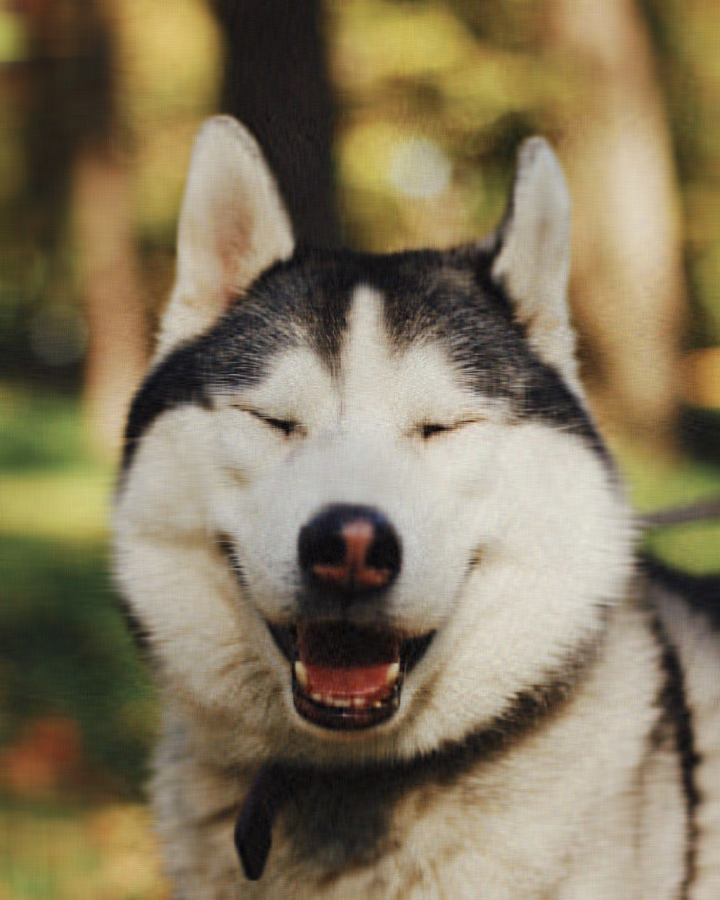

<ipython-input-11-5438ff7bddc3>:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  mssim = compare_ssim(compressed_image, reference_image, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


SVV for SVD compression: -0.13961394251316228
SVV for DCT compression: 0.0


In [ ]:
k = 60
path = '/content/image-file-compressed.jpeg'
recovered = cv.imread(path)
recovered = image.astype('float32')

print(f'SVV for SVD compression: {svv(k_rank_compressed_image(k, image), compressed_size(k, image), image, image.shape[0]*image.shape[1]*image.shape[2])}')
print(f'SVV for DCT compression: {svv(recovered, recovered.shape[0]*recovered.shape[1]*recovered.shape[2], image, image.shape[0]*image.shape[1]*image.shape[2])}')

As we can see, our SVD doesn't have the best value of metric, as it worsens the quality of our photo more than we compress our photo. On contrast, Automatic compression is  perfect, as the quality of photo after decompressing is the same as before. We can conclude, that our SVD is not better than built-in compression, but is still has not terrible values of SVV metric.

This is a space for your suggestions, comments, threats, etc...

No threats today...(((

😢





🦍 (monke)

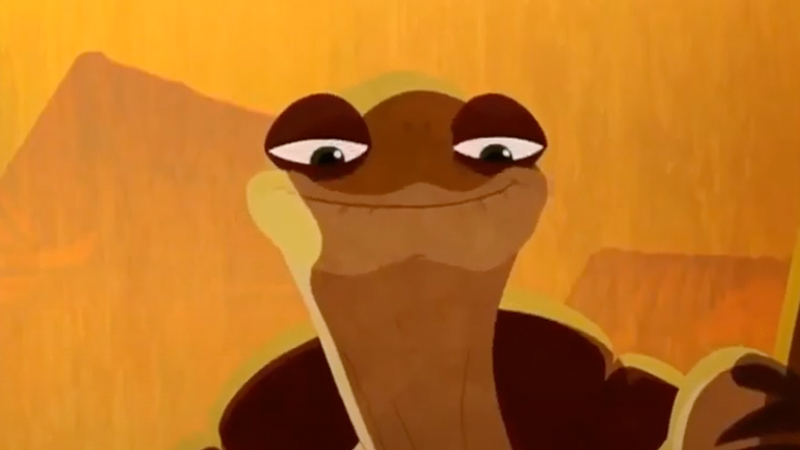